In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [16]:
# Load the data
df = pd.read_csv("../data/aqi_data_labeled.csv")

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract year for filtering
df['Year'] = df['Date'].dt.year

print(f"Data shape: {df.shape}")
print(f"\nYear distribution:")
print(df['Year'].value_counts().sort_index())
print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
df.head()


Data shape: (1095, 12)

Year distribution:
Year
2021    365
2022    365
2023    365
Name: count, dtype: int64

Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00


,Date,AQI,PM25,Ozone,NO2,SO2,CO,Windspeed,Temperature,AQI_Label,AQI_Class,Year
0,2021-01-01,184,44.270025,0.020213,13.942799,0.527083,0.478506,93.572685,55.808013,Unsafe,2,2021
1,2021-01-02,77,14.630556,0.017611,17.015365,0.359028,0.490009,88.252161,53.503846,Safe,0,2021
2,2021-01-03,82,15.873148,0.018054,14.431703,0.252778,0.476316,80.265124,53.192308,Safe,0,2021
3,2021-01-04,77,17.684167,0.015154,18.255706,0.313889,0.553226,87.065278,53.570513,Safe,0,2021
4,2021-01-05,84,19.733333,0.011398,21.868150,0.257639,0.562243,83.821759,53.943910,Safe,0,2021


In [17]:
# Split data: 2021-2022 for training, 2023 for testing
train_df = df[df['Year'].isin([2021, 2022])].copy()
test_df = df[df['Year'] == 2023].copy()

print(f"Training set: {train_df.shape[0]} samples (2021-2022)")
print(f"Test set: {test_df.shape[0]} samples (2023)")

# Features for regression
feature_cols = ['PM25', 'Ozone', 'NO2', 'SO2', 'CO', 'Windspeed', 'Temperature']

# Prepare features and target
X_train = train_df[feature_cols]
y_train = train_df['AQI']
X_test = test_df[feature_cols]
y_test = test_df['AQI']

print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")


Training set: 730 samples (2021-2022)
Test set: 365 samples (2023)

Training features shape: (730, 7)
Test features shape: (365, 7)


In [18]:
xgb_model = xgb.XGBRegressor(
    n_estimators=75,   # Reduced number of trees
    max_depth=3,       # Further reduced from 4 to 3 to reduce overfitting
    learning_rate=0.1,
    reg_alpha=0.5,     # Increased L1 regularization (from 0.1 to 0.5)
    reg_lambda=2.0,    # Increased L2 regularization (from 1.0 to 2.0)
    min_child_weight=5, # Increased from 3 to 5 to prevent overfitting on small nodes
    subsample=0.7,     # Reduced from 0.8 to 0.7 for more randomness
    colsample_bytree=0.7, # Reduced from 0.8 to 0.7 for more randomness
    random_state=42,
    objective='reg:squarederror'
)

# Train the model
xgb_model.fit(X_train, y_train)

print("Model training complete")

Model training complete


In [19]:

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=" * 50)
print("REGRESSION METRICS")
print("=" * 50)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")
print(f"  R²:   {train_r2:.4f}")
print(f"\nTest Set (2023):")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE:  {test_mae:.2f}")
print(f"  R²:   {test_r2:.4f}")
print("=" * 50)


REGRESSION METRICS

Training Set:
  RMSE: 12.69
  MAE:  8.55
  R²:   0.8652

Test Set (2023):
  RMSE: 16.74
  MAE:  11.27
  R²:   0.8207


In [ ]:
# Calculate the gap between train and test performance
# added this cell due to chanigng our regressors to check overfitting or underfitting
rmse_gap = test_rmse - train_rmse
mae_gap = test_mae - train_mae
r2_gap = train_r2 - test_r2

print("=" * 50)
print("OVERFITTING ANALYSIS")
print("=" * 50)
print(f"RMSE Gap (Test - Train): {rmse_gap:.2f}")
print(f"MAE Gap (Test - Train): {mae_gap:.2f}")
print(f"R² Gap (Train - Test): {r2_gap:.4f}")
print(f"\nTest RMSE / Train RMSE ratio: {test_rmse/train_rmse:.2f}x")
print(f"Test MAE / Train MAE ratio: {test_mae/train_mae:.2f}x")
print("=" * 50)

# Interpretation
if test_rmse / train_rmse > 2.0:
    print("⚠️  WARNING: Significant overfitting detected!")
    print("   Consider reducing model complexity or adding more regularization.")
elif test_rmse / train_rmse > 1.5:
    print("⚠️  CAUTION: Some overfitting may be present.")
else:
    print("✓ Model generalization looks reasonable.")


OVERFITTING ANALYSIS
RMSE Gap (Test - Train): 4.05
MAE Gap (Test - Train): 2.72
R² Gap (Train - Test): 0.0445

Test RMSE / Train RMSE ratio: 1.32x
Test MAE / Train MAE ratio: 1.32x
✓ Model generalization looks reasonable.


Feature Importance:
       feature  importance
6  Temperature    0.240574
1        Ozone    0.209214
0         PM25    0.175569
5    Windspeed    0.139514
4           CO    0.097641
2          NO2    0.079124
3          SO2    0.058365


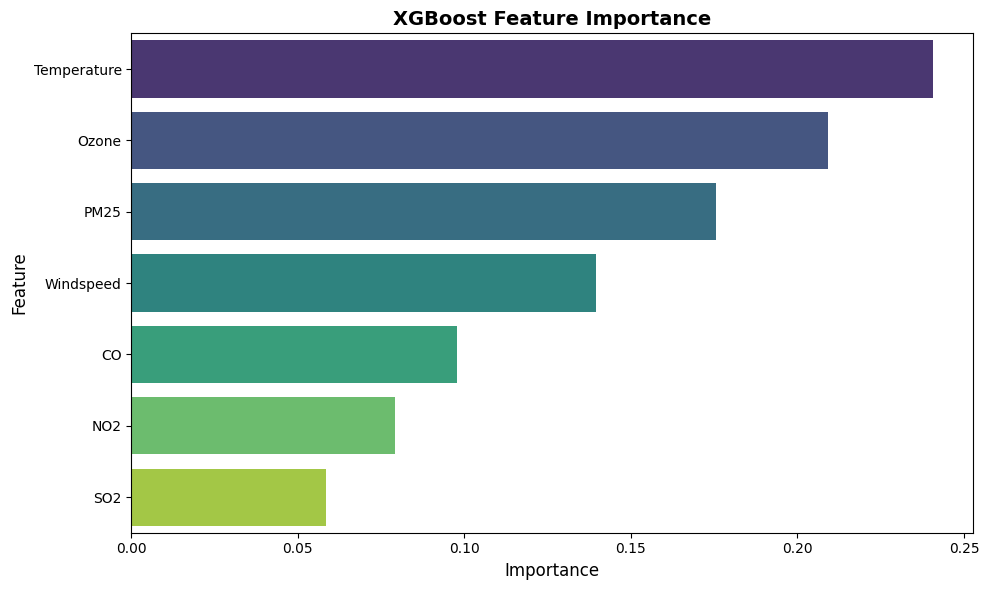

In [21]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


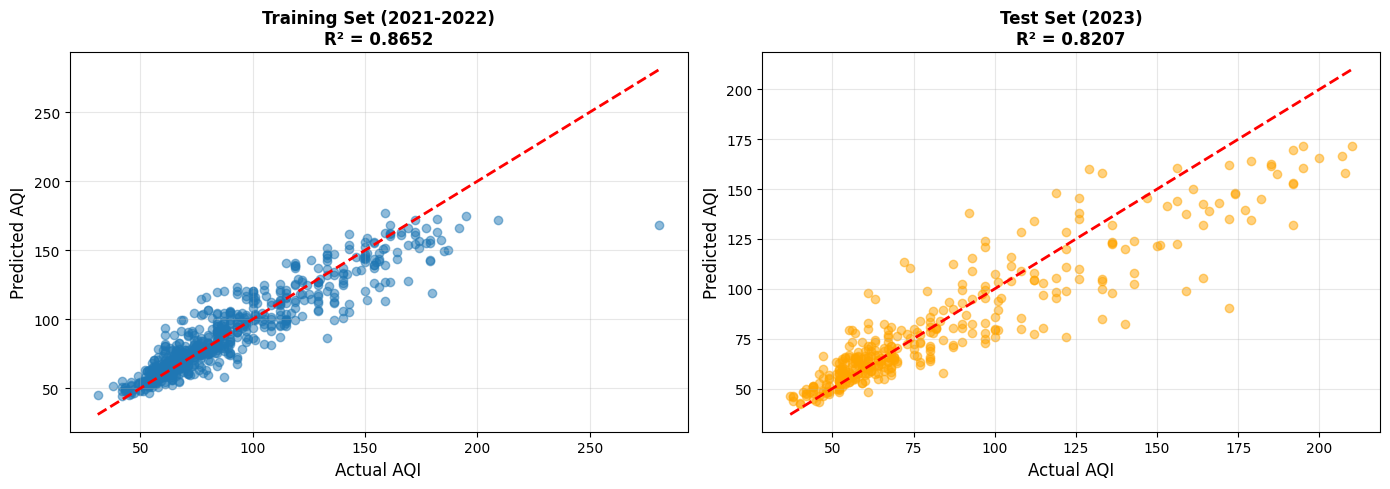

In [22]:
# Plot predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual AQI', fontsize=12)
axes[0].set_ylabel('Predicted AQI', fontsize=12)
axes[0].set_title(f'Training Set (2021-2022)\nR² = {train_r2:.4f}', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual AQI', fontsize=12)
axes[1].set_ylabel('Predicted AQI', fontsize=12)
axes[1].set_title(f'Test Set (2023)\nR² = {test_r2:.4f}', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


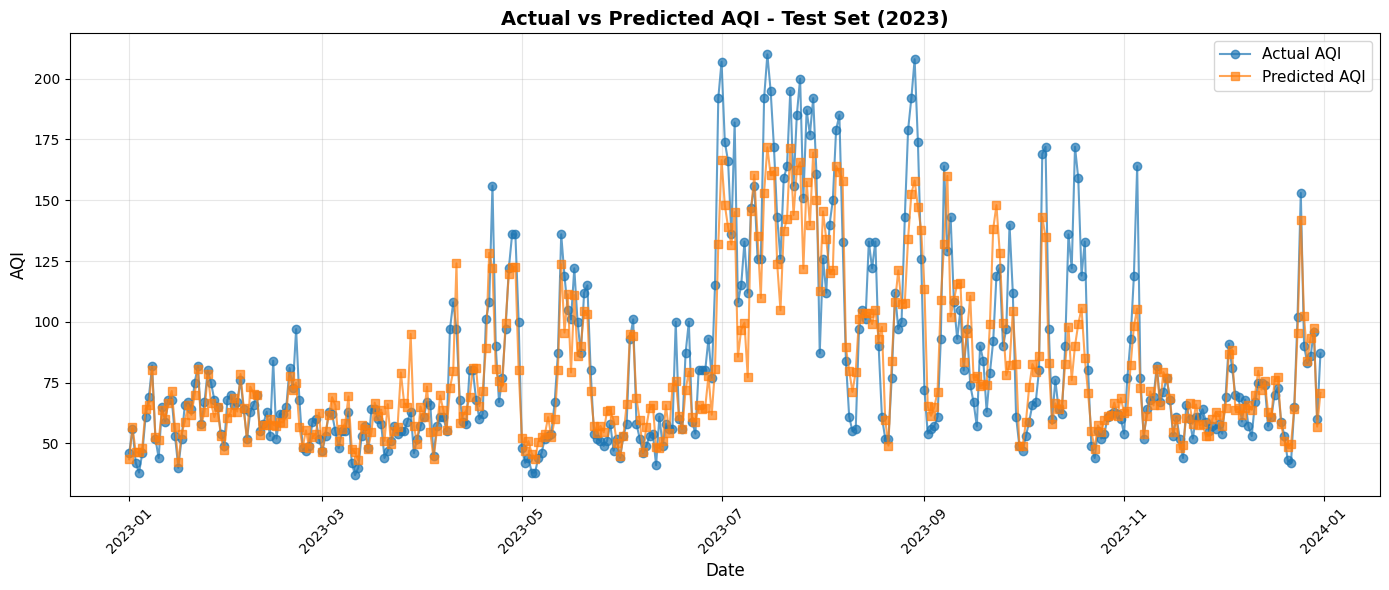

In [23]:
# Time series plot of predictions vs actual for test set
test_df_with_pred = test_df.copy()
test_df_with_pred['Predicted_AQI'] = y_test_pred

plt.figure(figsize=(14, 6))
plt.plot(test_df_with_pred['Date'], test_df_with_pred['AQI'], label='Actual AQI', marker='o', alpha=0.7)
plt.plot(test_df_with_pred['Date'], test_df_with_pred['Predicted_AQI'], label='Predicted AQI', marker='s', alpha=0.7)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.title('Actual vs Predicted AQI - Test Set (2023)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# Create a comprehensive table of the test set results
test_results = test_df.copy()
test_results['Predicted_AQI'] = y_test_pred
test_results['Error'] = test_results['AQI'] - test_results['Predicted_AQI']
test_results['Absolute_Error'] = np.abs(test_results['Error'])

# Select relevant columns for the table
results_table = test_results[[
    'Date', 
    'AQI', 
    'Predicted_AQI', 
    'Error', 
    'Absolute_Error',
    'PM25', 
    'Ozone', 
    'NO2', 
    'SO2', 
    'CO', 
    'Windspeed', 
    'Temperature'
]].copy()

# Round numeric columns for better display
results_table['Predicted_AQI'] = results_table['Predicted_AQI'].round(2)
results_table['Error'] = results_table['Error'].round(2)
results_table['Absolute_Error'] = results_table['Absolute_Error'].round(2)

print("Test Set Results Table (2023)")
print("=" * 120)
display(results_table)


Test Set Results Table (2023)


,Date,AQI,Predicted_AQI,Error,Absolute_Error,PM25,Ozone,NO2,SO2,CO,Windspeed,Temperature
730,2023-01-01,46,43.490002,2.51,2.51,5.073485,0.026594,3.976566,0.094792,0.169563,127.385590,54.155303
731,2023-01-02,56,56.820000,-0.82,0.82,8.040909,0.021909,11.794345,0.122917,0.315032,77.428993,50.378788
732,2023-01-03,42,46.330002,-4.33,4.33,3.164583,0.021818,8.009882,0.016667,0.211701,48.099306,52.871212
733,2023-01-04,38,46.330002,-8.33,8.33,2.675758,0.028931,8.012171,-0.019792,0.207137,65.193924,57.284091
734,2023-01-05,46,48.259998,-2.26,2.26,5.080303,0.024342,7.527989,0.010132,0.204923,92.789236,55.291667
...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,83,83.839996,-0.84,0.84,19.009848,0.012944,19.475755,0.210417,0.635831,92.912674,55.703820
1091,2023-12-28,86,93.529999,-7.53,7.53,20.170455,0.014233,18.903045,0.090800,0.560316,89.338889,55.167014
1092,2023-12-29,96,97.370003,-1.37,1.37,20.522619,0.019399,20.055340,0.147024,0.619340,84.563368,55.319792
1093,2023-12-30,60,56.910000,3.09,3.09,8.357955,0.021750,10.312849,0.023958,0.315193,88.363368,55.310417
